

---





<h3 align="center">⚽¿Se puede predecir en qué posición juega un jugador de 
fútbol?⚽</h3> 



---




Dataset
Concretamente, el dataset de entrenamiento esta compuesto de datos de alrededor de 20.000 jugadores de FIFA y por cada jugador existen 53 características o features que se describen a continuación.

-----Features basadas en datos del jugador-----

ID Name Sex Nationality Overal Potential Height Weight PreferredFoot BirthDate Age PlayerWorkRate WeakFoot SkillMoves Value Wage Club Club_KitNumber Club_JoinedClub Club_ContractLength

-----Features basadas en habilidades del jugador-----

BallControl Dribbling Marking SlideTackle StandTackle Aggression Reactions Interceptions Vision Composure Crossing ShortPass LongPass Acceleration Stamina Strength Balance SprintSpeed Agility Jumping Heading ShotPower Finishing LongShots Curve FKAcc Penalties Volleys GKDiving GKHandling GKKicking GKReflexes

En estas estadísticas se basa el juego para determinar las probabilidades de éxito de una acción determinada. Están en una escala del 1 al 100.

-----Etiqueta-----

Position: Indica si juega como arquero (GK), defensor (DEF), mediocampista (MID) o delantero (FWD). Este es el valor que intentaremos predecir.

Separación en 2 archivos
El archivo fifa2021_training.csv contiene el 70% de los datos totales incluyendo la etiqueta real.

El archivo fifa2021_test.csv contiene el 30% de los datos totales SIN INCLUIR la etiqueta real. Estas etiquetas faltantes están ocultas y se usarán para determinar qué modelo anda mejor al compararlas con las predicciones obtenidas.

# **Librerias/Frameworks**

In [ ]:
#Manejo de datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#conexión con google drive
from google.colab import drive 

#visualización
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

#Modelo Pytorch
import torchvision
import torchvision.transforms as transforms
import torch

#Metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

# **Preprocesamiento de los datos**

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/DeepLearning/Tps/Fifa/fifa_training.csv')

In [ ]:
#Elimino columnas que no demuestran ser buenas clasificadoras del target
data.drop(columns=["Release Clause", "Loaned From", "Joined", "Club", "Contract Valid Until", "DataPoint", "International Reputation", "Name", "Photo", "Nationality", "Flag", "Potential", "Club Logo", "Real Face", "Overall"], axis = 1, inplace=True)

In [ ]:
data.head(2)

,ID,Age,Value,Wage,Special,Preferred Foot,Weak Foot,Skill Moves,Work Rate,Body Type,Jersey Number,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Position
0,244360,22,190K,1K,1261,Right,3,2,Medium/ Medium,Lean,2,6'2,161lbs,26,26,45,30,30,32,22,23,28,43,60,70,41,48,55,35,68,54,77,19,64,52,21,35,37,46,59,62,58,9,7,8,7,10,DEF
1,219577,26,500K,1K,1449,Right,2,2,Medium/ Medium,Lean,13,6'1,172lbs,39,21,61,49,37,30,38,29,40,44,59,65,57,59,71,51,71,62,66,25,65,61,26,33,41,60,67,68,66,10,13,10,7,8,DEF


In [ ]:
print(f"En base al dataframe analizado hay: {data.shape[0]} observaciones.")

En base al dataframe analizado hay: 12702 observaciones.


In [ ]:
print(f"En base al dataframe analizado hay: {data.shape[1]} columnas.")

En base al dataframe analizado hay: 48 columnas.


In [ ]:
print(f"Valores nulos = {data.isna().sum().sum()}")

Valores nulos = 0


In [ ]:
def analizar(data2):
  var = data2.columns
  tab_control = pd.DataFrame({"variable":var})
  tab_control["valores_unicos"] = ""
  for i in range(tab_control.shape[0]):
    v = tab_control.loc[i,"variable"]
    tab_control.loc[i, "valores_unicos"] = data2[v].unique()
  tab_control["cantidad"] = ""
  for i in range(tab_control.shape[0]):
    long = len(tab_control.loc[i,"valores_unicos"])
    tab_control.loc[i,"cantidad"] = long
  tab_control["tiene_nulos"] = ""
  for i in range(tab_control.shape[0]):
    x = pd.isnull(tab_control.loc[i,"valores_unicos"]).sum()
    tab_control.loc[i,"tiene_nulos"] = x
  tab_control["cant_nulos"] = ""
  for i in range(tab_control.shape[0]):
    if tab_control.loc[i,"tiene_nulos"] == 1:
      cat = tab_control.loc[i,"variable"]
      cant = data2[cat].isnull().sum()
      tab_control.loc[i, "cant_nulos"] = cant
    else:
      tab_control.loc[i, "cant_nulos"] = 0
  return tab_control

In [ ]:
data.Value.isna().sum()

0

In [ ]:
#Analisis general

pd.set_option('display.max_rows', None)
control = analizar(data).sort_values("cant_nulos", ascending = False)
control

,variable,valores_unicos,cantidad,tiene_nulos,cant_nulos
0,ID,"[244360, 219577, 232603, 236522, 241670, 22678...",12702,0,0
1,Age,"[22, 26, 23, 18, 21, 24, 31, 30, 19, 34, 27, 3...",28,0,0
26,Reactions,"[48, 59, 62, 67, 54, 66, 55, 76, 45, 63, 82, 5...",67,0,0
27,Balance,"[55, 71, 61, 74, 67, 66, 38, 79, 80, 78, 81, 5...",81,0,0
28,ShotPower,"[35, 51, 64, 62, 61, 48, 65, 60, 80, 43, 68, 5...",91,0,0
29,Jumping,"[68, 71, 75, 62, 65, 61, 81, 51, 64, 72, 55, 5...",71,0,0
30,Stamina,"[54, 62, 53, 67, 66, 76, 64, 69, 56, 72, 78, 4...",84,0,0
31,Strength,"[77, 66, 76, 60, 67, 70, 59, 57, 72, 47, 63, 4...",74,0,0
32,LongShots,"[19, 25, 15, 63, 52, 28, 59, 69, 56, 35, 70, 4...",91,0,0
33,Aggression,"[64, 65, 40, 68, 60, 52, 48, 57, 63, 35, 58, 7...",84,0,0


In [ ]:
#Tipos de datos, los objetos deberan pasarse a float o int.
data.dtypes

ID                  int64
Age                 int64
Value              object
Wage               object
Special             int64
Preferred Foot     object
Weak Foot           int64
Skill Moves         int64
Work Rate          object
Body Type          object
Jersey Number       int64
Height             object
Weight             object
Crossing            int64
Finishing           int64
HeadingAccuracy     int64
ShortPassing        int64
Volleys             int64
Dribbling           int64
Curve               int64
FKAccuracy          int64
LongPassing         int64
BallControl         int64
Acceleration        int64
SprintSpeed         int64
Agility             int64
Reactions           int64
Balance             int64
ShotPower           int64
Jumping             int64
Stamina             int64
Strength            int64
LongShots           int64
Aggression          int64
Interceptions       int64
Positioning         int64
Vision              int64
Penalties           int64
Composure   

In [ ]:
pd.reset_option("display.max_rows")

In [ ]:
def value_to_float(x):
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0

def weight_to_float(x):
  return float(x.replace('lbs', ''))


def height_to_float(x):
  return float(x.replace("'", '.'))

In [ ]:
#Transformar a float las columnas Value y Wage que tenian abreviacion con K y M (strings)
data['Value'] = data['Value'].apply(value_to_float)
data['Wage'] = data['Wage'].apply(value_to_float)

#Transformar Wight y Height a float (eran strings)
data['Weight'] = data['Weight'].apply(weight_to_float)
data['Height'] = data['Height'].apply(height_to_float)

#Divido la columna Work Rate en AttackRate y DefenseRate, asigno numeros a las categorias.
data[['AttackRate', 'DefenseRate']] = data['Work Rate'].str.split('/', 1, expand=True)
data.DefenseRate = data.DefenseRate.str.strip()
data.AttackRate.replace({"Low":1, "Medium":2, "High":3}, inplace = True)
data.DefenseRate.replace({"Low":1, "Medium":2, "High":3}, inplace = True)
data.DefenseRate = data.DefenseRate.apply(lambda x: int(x))
data.AttackRate = data.AttackRate.apply(lambda x: int(x))
data.loc[:,["Work Rate", "AttackRate", "DefenseRate"]].head(5)

,Work Rate,AttackRate,DefenseRate
0,Medium/ Medium,2,2
1,Medium/ Medium,2,2
2,Medium/ High,2,3
3,Medium/ Medium,2,2
4,Low/ High,1,3


In [ ]:
data.drop("Work Rate", axis = 1, inplace = True) #Ahora sí, elimino la columna Work Rate

In [ ]:
#Ciertos jugadores tienen un Body Type su propio valor (igual a su nombre), estos casos se reemplaza por la moda.
lista = ['Shaqiri', 'Messi', 'Courtois','Akinfenwa', 'PLAYER_BODY_TYPE_25', 'C. Ronaldo', 'Neymar']
data["Body Type"] = np.where(data["Body Type"].isin(lista), data["Body Type"].mode()[0], data["Body Type"])
#Paso a variable dummie
data = pd.get_dummies(data, columns = ['Body Type', 'Preferred Foot'])

In [ ]:
data.head(5)

,ID,Age,Value,Wage,Special,Weak Foot,Skill Moves,Jersey Number,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Position,AttackRate,DefenseRate,Body Type_Lean,Body Type_Normal,Body Type_Stocky,Preferred Foot_Left,Preferred Foot_Right
0,244360,22,190000.0,1000.0,1261,3,2,2,6.2,161.0,26,26,45,30,30,32,22,23,28,43,60,70,41,48,55,35,68,54,77,19,64,52,21,35,37,46,59,62,58,9,7,8,7,10,DEF,2,2,1,0,0,0,1
1,219577,26,500000.0,1000.0,1449,2,2,13,6.1,172.0,39,21,61,49,37,30,38,29,40,44,59,65,57,59,71,51,71,62,66,25,65,61,26,33,41,60,67,68,66,10,13,10,7,8,DEF,2,2,1,0,0,0,1
2,232603,23,290000.0,2000.0,1282,2,2,23,6.0,165.0,28,20,56,42,23,25,29,23,29,31,65,69,38,48,61,35,75,53,76,15,64,57,29,30,32,52,59,63,62,13,6,8,12,6,DEF,2,3,0,1,0,0,1
3,236522,18,3700000.0,12000.0,1627,3,3,99,5.6,159.0,65,66,53,69,45,73,48,45,63,72,74,76,77,62,74,64,62,67,60,63,40,20,73,65,60,50,23,12,13,14,6,10,8,5,MID,2,2,0,1,0,1,0
4,241670,26,1900000.0,15000.0,1785,3,2,6,6.1,170.0,57,45,64,77,59,61,58,40,75,73,66,64,62,62,67,62,65,66,67,63,64,64,43,64,44,63,65,73,70,7,8,10,11,9,MID,1,3,1,0,0,0,1


In [ ]:
data.Value.isna().sum() #Habia valores igual a cero en Value y Wage

164

In [ ]:
data.Wage.isna().sum()

158

In [ ]:
data.fillna(data.loc[:,["Value", "Wage"]].mean(), inplace= True) #Remplazo nulos por la media
data.columns

Index(['ID', 'Age', 'Value', 'Wage', 'Special', 'Weak Foot', 'Skill Moves',
       'Jersey Number', 'Height', 'Weight', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Position', 'AttackRate',
       'DefenseRate', 'Body Type_Lean', 'Body Type_Normal', 'Body Type_Stocky',
       'Preferred Foot_Left', 'Preferred Foot_Right'],
      dtype='object')

# **Visualizacion de datos**

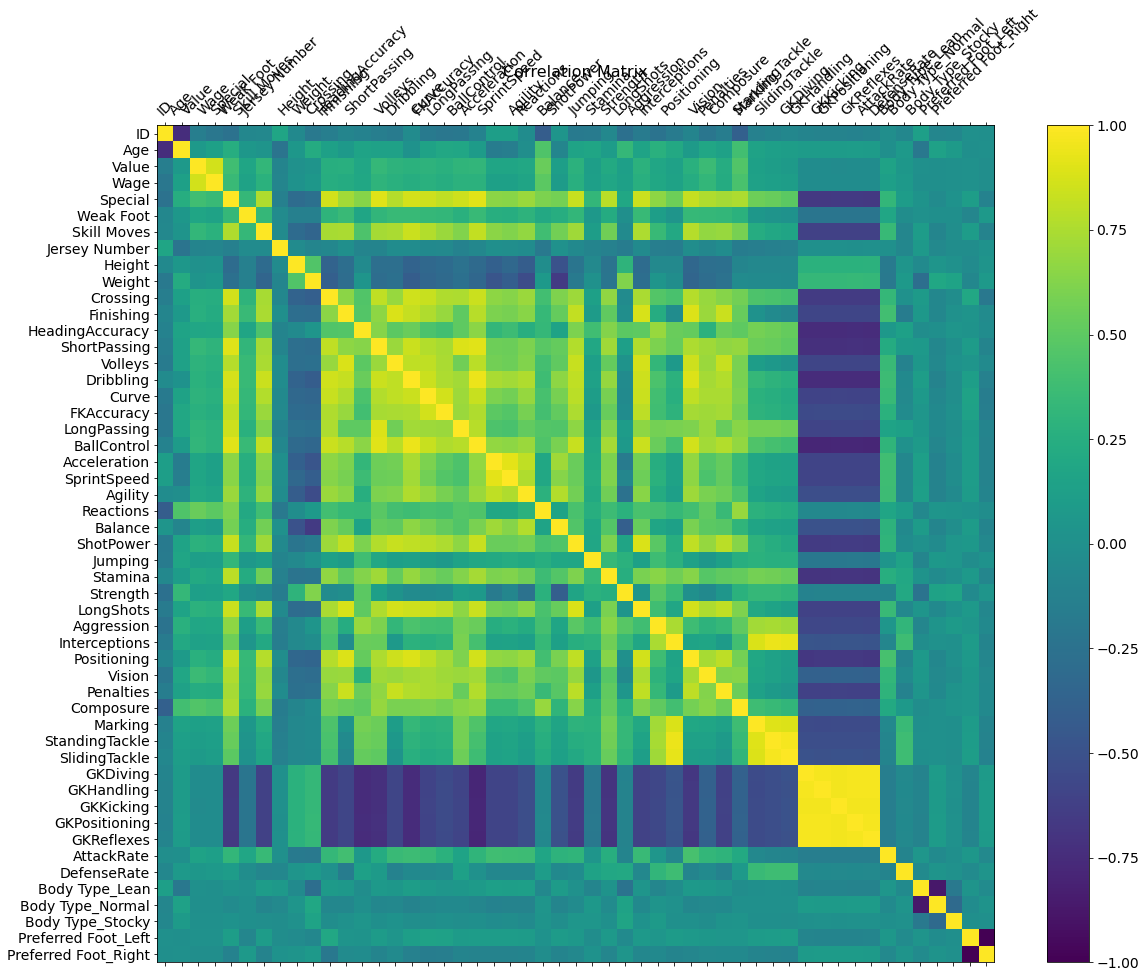

In [ ]:
df = data
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [ ]:
variable = "Crossing"

In [ ]:
px.histogram(data_frame = data, x = variable, facet_col = "Position", histnorm='probability density' )

In [ ]:
px.violin(data_frame = data, y = variable, x = "Position", color = "Position", box = True, points = "all")

# **Preprocesamiento 2**

In [ ]:
data.Position.replace({"DEF":0, "MID":1, "FWD":2, "GK":3}, inplace = True)

In [ ]:
data.drop("ID", axis = 1, inplace = True)

In [ ]:
labels = [x for x in data.columns if x !="Position" and x != "Jersey Number"]

In [ ]:
data[labels] = data[labels].apply(lambda x: ((x-x.mean())/x.std()))


In [ ]:
data["Jersey Number"] = data["Jersey Number"].apply(lambda x: 0 if x == 0 else np.log(x))

# **Visualizacion 2**

In [ ]:
avg_data = data.groupby("Position", as_index=False).mean()
lista = ['Age', 'Value', 'Wage', 'Special', 'Weak Foot',
       'Skill Moves', 'Jersey Number', 'Height', 'Weight', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'AttackRate', 'DefenseRate',
       'Body Type_Lean', 'Body Type_Normal', 'Body Type_Stocky',
       'Preferred Foot_Left', 'Preferred Foot_Right']
df = pd.DataFrame(dict(
    r=avg_data.loc[0,lista].values,
    theta=lista))
fig = px.line_polar(df, r='r', theta='theta', line_close=True, title = "DEF")
fig.show()

In [ ]:
avg_data = data.groupby("Position", as_index=False).mean()
lista = ['Age', 'Value', 'Wage', 'Special', 'Weak Foot',
       'Skill Moves', 'Jersey Number', 'Height', 'Weight', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'AttackRate', 'DefenseRate',
       'Body Type_Lean', 'Body Type_Normal', 'Body Type_Stocky',
       'Preferred Foot_Left', 'Preferred Foot_Right']
df = pd.DataFrame(dict(
    r=avg_data.loc[1,lista].values,
    theta=lista))
fig = px.line_polar(df, r='r', theta='theta', line_close=True, title = "MID")
fig.show()

In [ ]:
avg_data = data.groupby("Position", as_index=False).mean()
lista = ['Age', 'Value', 'Wage', 'Special', 'Weak Foot',
       'Skill Moves', 'Jersey Number', 'Height', 'Weight', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'AttackRate', 'DefenseRate',
       'Body Type_Lean', 'Body Type_Normal', 'Body Type_Stocky',
       'Preferred Foot_Left', 'Preferred Foot_Right']
df = pd.DataFrame(dict(
    r=avg_data.loc[2,lista].values,
    theta=lista))
fig = px.line_polar(df, r='r', theta='theta', line_close=True, title = "FWD")
fig.show()

In [ ]:
lista = ["Position", 'Weak Foot', 'Skill Moves', 'Jersey Number', 'Height', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle','AttackRate', 'DefenseRate']
avg_data = data.loc[:, lista].groupby("Position", as_index=False).mean()
df = pd.DataFrame(dict(
    r=avg_data.loc[0,lista].values,
    theta=lista))
fig = px.line_polar(df, r='r', theta='theta', line_close=True, title = "GK")
fig.show()

In [ ]:
lista = ["Position", 'Skill Moves', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']

In [ ]:
avg_data = data.loc[:, lista].groupby("Position").mean()

In [ ]:
fig = go.Figure()

for i in [0,1,2]:
    if i == 0:
      b= "Defensor"
    elif i == 1:
      b= "Mediocampista"
    else:
      b= "Delantero"
    fig.add_trace(
                go.Scatterpolar(
                                r=avg_data.iloc[i].values,
                                theta=avg_data.columns,
                                fill='toself',
                                name=b,
                                showlegend=True,
                                )
                )

fig.update_layout(
    polar=dict(
        radialaxis=dict(
                        visible=True,
                        range=[0, 1]
                    )
            ),
    title="Wine Variables According to Wine Categories"
)

fig.show()

In [ ]:
avg_data

,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
Position,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.206369,0.068347,-0.549112,0.502512,0.025596,-0.429350,-0.171784,-0.217424,-0.238413,0.046836,-0.052279,-0.045165,0.019699,-0.233267,-0.188845,-0.244899,0.337413,0.294953,0.430259,-0.399148,0.553093,0.831613,-0.329658,-0.517762,-0.337965,-0.025569,0.843559,0.886385,0.917055
1,0.472480,0.479706,0.440153,-0.018669,0.566082,0.444836,0.527527,0.522968,0.573280,0.631375,0.503190,0.325899,0.257106,0.466622,0.490370,0.444299,-0.151559,0.313935,-0.294738,0.529333,0.145145,0.164978,0.459806,0.651661,0.382415,0.270525,0.162282,0.164311,0.136131
2,0.441019,0.044720,1.026654,0.438939,0.067798,0.821482,0.504330,0.339789,0.196792,-0.315084,0.415663,0.437862,0.470629,0.367194,0.193108,0.624213,0.095499,0.071005,0.070476,0.648277,-0.239126,-0.897500,0.772551,0.251899,0.842623,0.183382,-0.805108,-0.922201,-0.955824
3,-1.807266,-1.937278,-1.727015,-2.200461,-2.150355,-1.731272,-2.212115,-1.768638,-1.625696,-1.756553,-2.322925,-1.771463,-1.783799,-1.576181,-1.479239,-1.922517,-0.642801,-2.080702,-0.378031,-1.803630,-1.707652,-1.425673,-1.990053,-1.169884,-1.823177,-1.184948,-1.616168,-1.541045,-1.474413


# **Preprocesamiento Final**

In [ ]:
data.head(1)

,Age,Value,Wage,Special,Weak Foot,Skill Moves,Jersey Number,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Position,AttackRate,DefenseRate,Body Type_Lean,Body Type_Normal,Body Type_Stocky,Preferred Foot_Left,Preferred Foot_Right
0,-0.670452,-0.402528,-0.400739,-1.241761,0.081894,-0.486292,0.693147,0.895723,-0.320603,-1.295531,-1.015898,-0.433376,-1.971354,-0.737348,-1.245608,-1.375056,-1.14107,-1.619383,-0.935498,-0.312705,0.355947,-1.53814,-1.533215,-0.635963,-1.200017,0.244195,-0.58859,0.923802,-1.473879,0.466073,0.264025,-1.492766,-1.303587,-0.746274,-1.108164,0.594824,0.668075,0.588368,-0.427023,-0.551799,-0.495208,-0.548518,-0.369994,0,-0.42579,-0.165276,1.353034,-1.182308,-0.260974,-0.549616,0.549616


In [ ]:
#Elimino las ultimas columnas que no demuestran ser buenas clasificadoras del target
data.drop(["Body Type_Lean", "Value", "Wage","Body Type_Normal", "Body Type_Stocky", "Weak Foot", "Age", "Special", "Height", "Weight", "GKHandling",	"GKKicking",	"GKPositioning",	"GKReflexes", "Body Type_Lean",	"Body Type_Normal",	"Body Type_Stocky"], axis = 1, inplace = True)

In [ ]:
entrenamiento, validacion = train_test_split(data, test_size=0.2) #Split en entrenamiento y validacion

In [ ]:
entrenamiento.shape

(10161, 37)

In [ ]:
validacion.shape

(2541, 37)

In [ ]:
x = entrenamiento.loc[:, data.columns != "Position"] #Matriz de labels
y = entrenamiento.loc[:, "Position"] #Matriz de target

In [ ]:
train_target = torch.tensor(y.values.astype(np.float32))
train = torch.tensor(x.values.astype(np.float32)) 
train_tensor = torch.utils.data.TensorDataset(train, train_target) 

train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = 1129, shuffle = True) #Generador de batches de entrenamiento

In [ ]:
x = validacion.loc[:, data.columns != "Position"]
y = validacion.loc[:, "Position"] 

val_target = torch.tensor(y.values.astype(np.float32)) #Tensor target de validacion
val_label = torch.tensor(x.values.astype(np.float32))  #Tensor labels de validacion

In [ ]:
val_label.shape

torch.Size([2541, 36])

In [ ]:
val_target.shape

torch.Size([2541])

# **Modelo**

In [ ]:
def evaluate(x):
    model.eval()
    y_pred = model(x)
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

In [ ]:
#Genero el perceptron multicapa
model = torch.nn.Sequential(
    torch.nn.Linear(36, 33),  
    torch.nn.ReLU(),
    torch.nn.Linear(33, 30),
    torch.nn.ReLU(),
    torch.nn.Linear(30, 17),
    torch.nn.ReLU(),
    torch.nn.Linear(17, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 4)
)

#Funcion de perdida
criterion = torch.nn.CrossEntropyLoss()

#Algoritmo de optimizacion
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 50 #Numero de epocas que va a iterar. 70

l = []
model.train() #Le indico al modelo que va a entrenar

for e in range(1, epochs+1): 
    _l = []
    
    # iteramos por batches en el dataloader
    for x_b, y_b in train_loader:
        
        y_b = y_b.long()
        
        y_pred = model(x_b.view(1129,36)) #Ingreso labels al modelo

        loss = criterion(y_pred, y_b) #Calculo de funcion de perdida
        _l.append(loss.item())

        optimizer.zero_grad() # ponemos a cero los gradientes asi no se acumulan

        loss.backward() #calculamos los gradientes
        
        optimizer.step() # update de los pesos
    
    l.append(np.mean(_l))
    
    if not e % 1:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

y_pred = evaluate(val_label) #Evaluamos los datos de validacion
print("Validacion:")
print(f"Accuracy :{accuracy_score(val_target, y_pred.numpy())} ")
print(f"Accuracy balanceado:{balanced_accuracy_score(val_target, y_pred.numpy())} ")
print(f"Nro de epocas: {epochs}")

Epoch 1/50 Loss 1.37170
Epoch 2/50 Loss 1.35466
Epoch 3/50 Loss 1.34141
Epoch 4/50 Loss 1.33072
Epoch 5/50 Loss 1.32133
Epoch 6/50 Loss 1.31195
Epoch 7/50 Loss 1.30081
Epoch 8/50 Loss 1.28514
Epoch 9/50 Loss 1.26529
Epoch 10/50 Loss 1.24532
Epoch 11/50 Loss 1.22651
Epoch 12/50 Loss 1.20889
Epoch 13/50 Loss 1.19224
Epoch 14/50 Loss 1.17624
Epoch 15/50 Loss 1.16064
Epoch 16/50 Loss 1.14520
Epoch 17/50 Loss 1.12978
Epoch 18/50 Loss 1.11419
Epoch 19/50 Loss 1.09817
Epoch 20/50 Loss 1.08144
Epoch 21/50 Loss 1.06382
Epoch 22/50 Loss 1.04534
Epoch 23/50 Loss 1.02624
Epoch 24/50 Loss 1.00689
Epoch 25/50 Loss 0.98757
Epoch 26/50 Loss 0.96853
Epoch 27/50 Loss 0.94989
Epoch 28/50 Loss 0.93177
Epoch 29/50 Loss 0.91423
Epoch 30/50 Loss 0.89730
Epoch 31/50 Loss 0.88103
Epoch 32/50 Loss 0.86539
Epoch 33/50 Loss 0.85038
Epoch 34/50 Loss 0.83599
Epoch 35/50 Loss 0.82219
Epoch 36/50 Loss 0.80898
Epoch 37/50 Loss 0.79632
Epoch 38/50 Loss 0.78419
Epoch 39/50 Loss 0.77257
Epoch 40/50 Loss 0.76143
Epoch 41/

In [ ]:
#Matriz de confusion
confusion_matrix(val_target, y_pred)

array([[791,  49,   0,   0],
       [ 60, 832,  58,   0],
       [  1, 116, 360,   0],
       [  0,   0,   0, 274]])

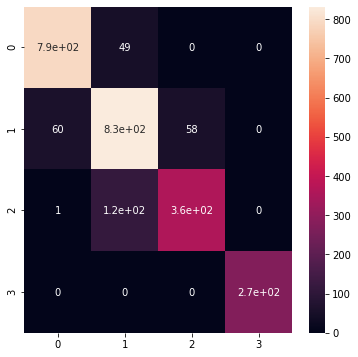

In [ ]:
plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix(val_target, y_pred), annot=True)

In [ ]:
'''
#Prediccion manual por id
id = 1
x = testeo.iloc[id, data.columns != "Position"]
testt = torch.tensor(x.values.astype(np.float32)) 
model.eval()
y_pred = model(testt)
print(testt.shape)
print(f"Prediccion: {np.argmax(y_pred.tolist())}")
print(f"Valor correcto:{testeo.iloc[id,42]}")
'''

'\n#Prediccion manual por id\nid = 1\nx = testeo.iloc[id, data.columns != "Position"]\ntestt = torch.tensor(x.values.astype(np.float32)) \nmodel.eval()\ny_pred = model(testt)\nprint(testt.shape)\nprint(f"Prediccion: {np.argmax(y_pred.tolist())}")\nprint(f"Valor correcto:{testeo.iloc[id,42]}")\n'